In [18]:
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

# Define functions and physical quantities for the calculation

In [2]:
def get_bragg_kout(kin, h, normal, compare_length=False):
    """
    This function produce the output wave vector from a Bragg reflection.

    :param kin: (3,) numpy array. The incident wave vector
    :param h: The reciprocal lattice of the crystal
    :param normal: The normal direction of the reflection surface.
                    For a bragg reflection, n is pointing to the inside of the crystal.
    :param compare_length: Whether compare the length of the incident wave vector and the output wave vector

    :return: kout: (3,) numpy array. The diffraction wave vector.
            ratio: When compare_length=True, the second output is the ratio between the incident wave number
                                        and the output wave number.
    """

    # kout holder
    kout = kin + h

    # Incident wave number
    klen = np.sqrt(np.dot(kin, kin))

    # Get gamma and alpha
    gammah = np.dot(kin + h, normal) / klen
    alpha = (2 * np.dot(kin, h) + np.dot(h, h)) / np.square(klen)

    if np.abs(-gammah - np.sqrt(gammah ** 2 - alpha)) > np.abs(-gammah + np.sqrt(gammah ** 2 - alpha)):
        momentum = klen * (-gammah + np.sqrt(gammah ** 2 - alpha))
    else:
        momentum = klen * (-gammah - np.sqrt(gammah ** 2 - alpha))

    # Add momentum transfer
    kout += normal * momentum

    if compare_length:
        return kout, klen / l2_norm(kout)
    else:
        return kout

In [3]:
# Some meta data for the delay line.
h_length = 2. * np.pi / (1.9201 * 1e-4)
bragg = np.radians(18.836) + 13e-6
klen0 = 50677.307588941476  # This is for 10keV photons. The unit is um^-1

# Calculate two wave vectors

In [4]:
# Get angles
phi = 1e-9
theta = bragg
alpha = np.deg2rad(10)

# Get physics quantities
h = np.array([h_length, 0, 0])
n = np.array([-np.cos(alpha),0,-np.sin(alpha)])
kin = np.array([-np.sin(theta), np.cos(theta), 0,]) * klen0

# Get rotation matrix
rot_mat = Rotation.from_euler('xyz',[0, 0, phi], degrees=False)
mat = rot_mat.as_dcm()

# Get wave vectors
kout = get_bragg_kout(kin = kin,
                      h = mat.dot(h),
                      normal = mat.dot(n))

kout0 = get_bragg_kout(kin = kin,
                       h = h,
                       normal = n)

# Calculate the derivative of the kout with respect to the rotation angle
# with the analytical expression

In [13]:
mis = np.deg2rad(-10)

ca = np.cos(mis)
sa = np.sin(mis)

ctheta = np.cos(bragg)
stheta = np.sin(bragg)

t = h_length / klen0

factor1 = ca ** 2 * stheta * ctheta + t * ctheta * sa ** 2
factor2 = np.sqrt( ca ** 2 * stheta ** 2 + 2 * t * stheta * sa ** 2 - t ** 2 * sa ** 2 )

In [14]:
# Get delta/phi/K_len
delta_over_phi = ca * ctheta + factor1 / factor2
print(delta_over_phi)

1.9220803848678898


In [15]:
# Get delta / phi * normal_z this is the z component of the gradient

delta_over_phi = (ca * ctheta + factor1 / factor2) * (-sa)

print(2 * np.cos(bragg) * np.sin(mis))
print(delta_over_phi)

-0.3286959927521278
0.33376575616166115


In [16]:
# Get the 3 derivatives with numerical difference.

print((kout[-1] - kout0[-1]) / phi / klen0)

-0.3337657463271634


# Loop through all cases

In [17]:
alphas = np.arange(-300, 301) / 10

analytical = np.zeros(601)
numerical = np.zeros(601)
approximation = np.zeros(601)

for x in range(601):

    ########################################################
    #      Numerical
    ########################################################
    # Get angles
    phi = 1e-9
    theta = bragg
    alpha = np.deg2rad(alphas[x])

    # Get physics quantities
    h = np.array([h_length, 0, 0])
    n = np.array([-np.cos(alpha),0,-np.sin(alpha)])
    kin = np.array([-np.sin(theta), np.cos(theta), 0,]) * klen0

    # Get rotation matrix
    rot_mat = Rotation.from_euler('xyz',[0, 0, phi], degrees=False)
    mat = rot_mat.as_dcm()

    # Get wave vectors
    kout = get_bragg_kout(kin = kin,
                          h = mat.dot(h),
                          normal = mat.dot(n))

    kout0 = get_bragg_kout(kin = kin,
                           h = h,
                           normal = n)
    
    numerical[x] = (kout[-1] - kout0[-1]) / phi / klen0
    
    
    ########################################################
    #      Analytical
    ########################################################
    mis = alpha
    ca = np.cos(mis)
    sa = np.sin(mis)

    ctheta = np.cos(bragg)
    stheta = np.sin(bragg)

    t = h_length / klen0

    factor1 = ca ** 2 * stheta * ctheta + t * ctheta * sa ** 2
    factor2 = np.sqrt( ca ** 2 * stheta ** 2 + 2 * t * stheta * sa ** 2 - t ** 2 * sa ** 2 )
    
    analytical[x] =delta_over_phi = (ca * ctheta + factor1 / factor2) * (-sa)

        
    ########################################################
    #      Approximation
    ########################################################
    approximation[x] = 2 * np.cos(bragg) * np.sin(mis)

[]

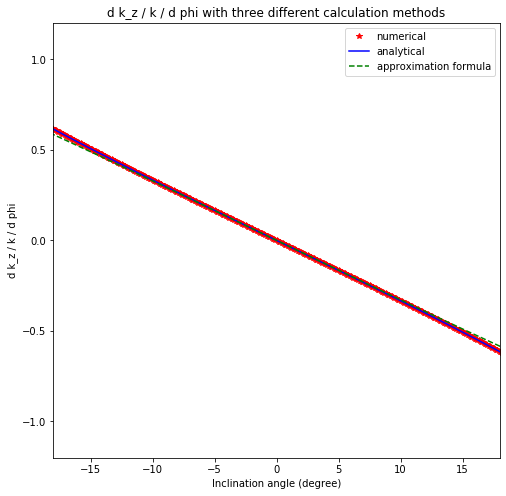

In [32]:
plt.figure(figsize=(8, 8))

plt.plot(alphas, numerical, 'r*', label = 'numerical')
plt.plot(alphas, analytical, 'b', label = 'analytical')
plt.plot(alphas, -approximation, 'g--', label = 'approximation formula')

plt.xlim([-18, 18])
plt.title("d k_z / k / d phi with three different calculation methods")
plt.xlabel("Inclination angle (degree)")
plt.ylabel("d k_z / k / d phi")
plt.legend()
plt.plot()